In [329]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [330]:
fixtures = pd.read_pickle("../../data/processed/fixtures_with_ratings_latest.pkl").rename(columns={'is_home':'was_home'})

In [331]:
first_10 = fixtures.loc[fixtures.gw < 11]

In [332]:
players_latest = pd.read_pickle('../../data/raw/cleaned_players_latest.pkl')

In [333]:
gameweek_df = pd.read_pickle('../../data/gameweek_with_ma.pkl')

In [334]:
model_cv = pickle.load(open('../../models/lightgbm_all_data.pkl', 'rb'))
MODEL_VALS = pickle.load(open('../../models/lightgbm_model_cols.pkl','rb'))

In [335]:
prev_season_df = (gameweek_df.sort_values(by='Date').drop_duplicates(['clean_name'],keep='last')[['clean_name']+MODEL_VALS]
.drop(columns=['gw','value','was_home','match_outcome_rating_1', 'match_outcome_rating_2', 'match_outcome_rating_diff', 'match_outcome_e',
                                        'exp_goal_diff_rating_1', 'exp_goal_diff_rating_2', 'exp_goal_diff_rating_diff', 'exp_goal_diff_e',
              'position_DEF', 'position_FWD',
       'position_GK', 'position_MID']))

In [336]:
players_latest['clean_name'] = players_latest.first_name + '_' + players_latest.second_name

In [344]:
players_latest.rename(columns={'team':'team_number'},inplace=True)

In [351]:
combined_df = prev_season_df.merge(players_latest.loc[:,['selected_by_percent','now_cost','clean_name','team_number','pos',
                                                         'position_DEF', 'position_FWD', 'position_GK', 'position_MID',]],on='clean_name')

In [352]:
team_numbers = pd.read_csv("../../data/external/team_numbers.csv")

In [353]:
combined_df = combined_df.merge(team_numbers.loc[team_numbers.season == '2019-20'],on='team_number')

In [354]:
combined_df.loc[combined_df.clean_name.str.contains('Trent')]

,clean_name,transfers_balance,transfers_in,transfers_out,ewma_assists,ewma_attempted_passes,ewma_big_chances_created,ewma_big_chances_missed,ewma_bonus,ewma_bps,...,selected_by_percent,now_cost,team_number,pos,position_DEF,position_FWD,position_GK,position_MID,team,season
157,Trent_Alexander-Arnold,203733,209853,6120,0.754402,58.307961,0.451551,0.023836,1.270267,27.500826,...,28.7,70,10,DEF,1,0,0,0,Liverpool,2019-20


In [355]:
forecast_df = first_10.merge(combined_df,on='team')

In [356]:
forecast_df['value'] = forecast_df.now_cost

In [357]:
forecast_df['transfers_in'] = (forecast_df.transfers_in.mean() / forecast_df.selected_by_percent.mean() ) * forecast_df.selected_by_percent
forecast_df['transfers_out'] = 0
forecast_df['transfers_balance'] = forecast_df.transfers_in - forecast_df.transfers_out

In [358]:
forecast_df['score_forecast'] = model_cv.predict(forecast_df[MODEL_VALS])

In [359]:
selection_df = forecast_df.groupby(['clean_name','pos','team'])[['score_forecast','value','selected_by_percent']].mean().reset_index().sort_values(by='score_forecast',ascending=False)

In [360]:
selection_df.to_pickle('../../data/processed/live_selections.pkl')

In [361]:
selection_df.head(20)

,clean_name,pos,team,score_forecast,value,selected_by_percent
361,Trent_Alexander-Arnold,DEF,Liverpool,8.811152,70,28.7
330,Sadio_Mané,MID,Liverpool,7.225065,115,24.8
369,Virgil_van Dijk,DEF,Liverpool,6.953997,65,42.7
171,Jamie_Vardy,FWD,Leicester City,6.912983,90,11.3
22,Andrew_Robertson,DEF,Liverpool,6.902782,70,36.2
66,Chris_Wood,FWD,Burnley,6.749028,65,1.2
272,Mohamed_Salah,MID,Liverpool,6.651129,125,36.5
384,Youri_Tielemans,MID,Leicester City,6.622786,65,5.7
311,Ricardo Domingos_Barbosa Pereira,DEF,Leicester City,6.540986,60,8.0
2,Aaron_Wan-Bissaka,DEF,Manchester United,6.402908,55,32.4


In [362]:
import shap

In [363]:
def explain_player(player, model):
    print(player)
    explainer = shap.TreeExplainer(model)
    player_df =forecast_df.loc[forecast_df.clean_name==player,MODEL_VALS].iloc[[0],:]
    shap_values = explainer.shap_values(player_df)
    return shap.force_plot(explainer.expected_value, shap_values, player_df,matplotlib=True)
    

Raheem_Sterling


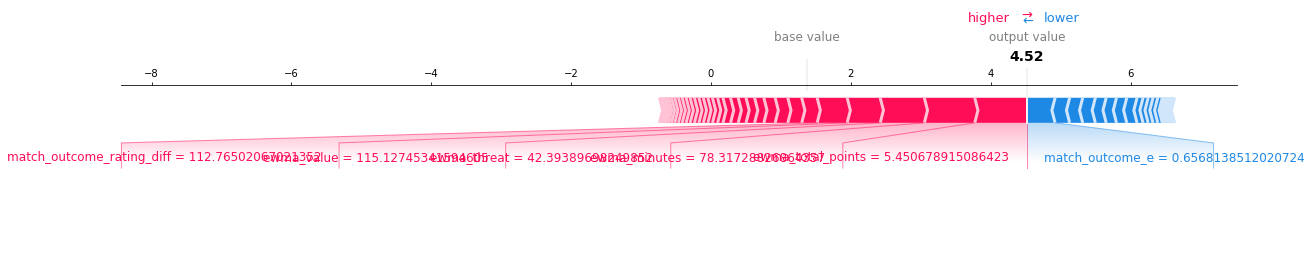

Harry_Kane


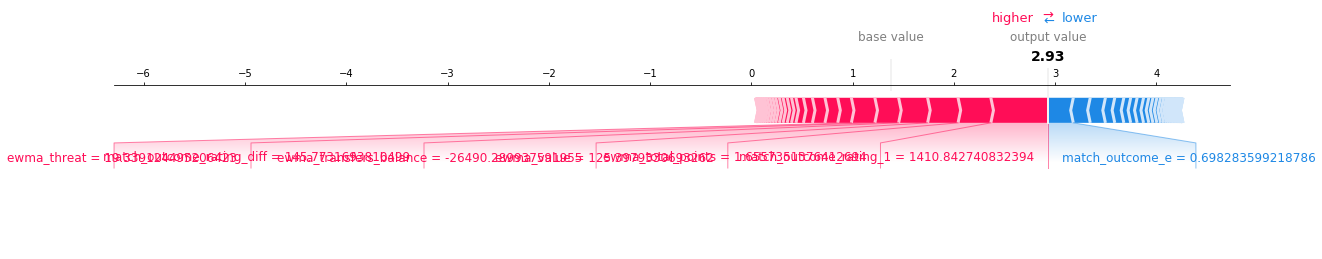

Trent_Alexander-Arnold


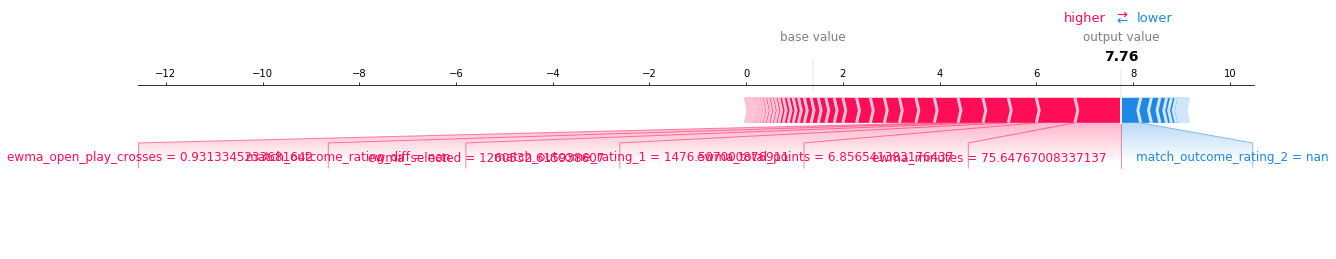

Sadio_Mané


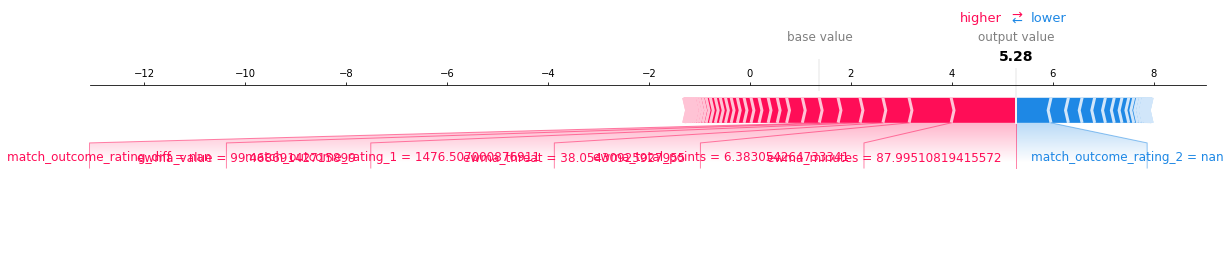

Ryan_Fraser


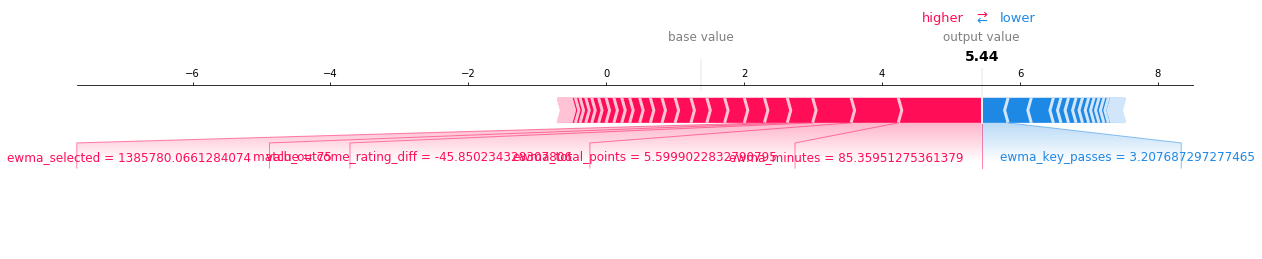

Jamie_Vardy


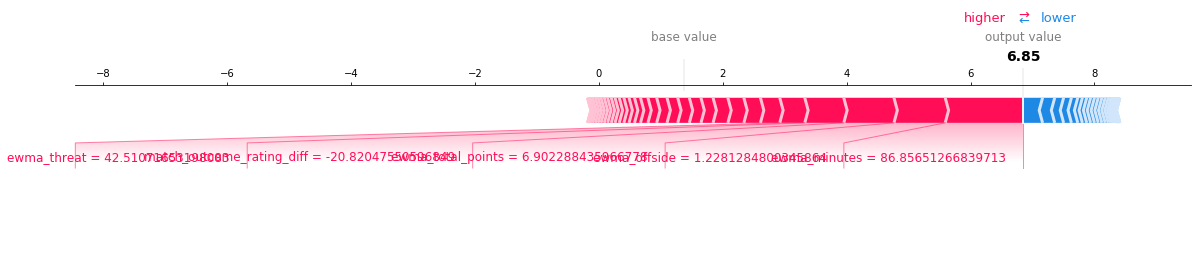

Shane_Duffy


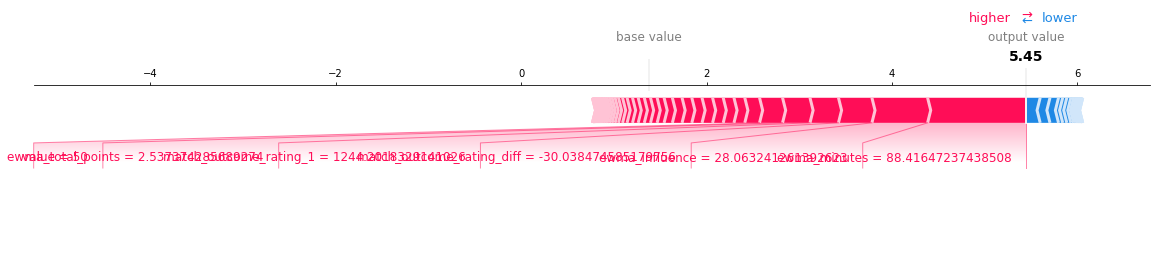

In [364]:
for p in ['Raheem_Sterling','Harry_Kane','Trent_Alexander-Arnold','Sadio_Mané','Ryan_Fraser','Jamie_Vardy','Shane_Duffy']:
    explain_player(p, model_cv)